Elapsed time:  1.5471417903900146 s


(0.001503171534559864,
 0.0015881791582682805,
 0.0013966701898095817,
 0.001469408088440593)

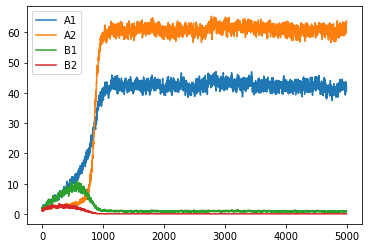

In [74]:
# This code implements a multiscale brain network model
# The model connects large-scale populations
# with a small-scale functional circuit for decision-making
# and working memory.
# The large-scale model uses "ReducedWongWangDeco" 
# neural mass models 
# -> Deco et al., 2014, Journal of Neuroscience
# The functional circuit was taken from 
# Murray et al., 2017, Journal of Neuroscience
#
# The model by Deco2014 was modified to allow for simulation
# of the effect of varying levels of long-range excitation
# versus feedforward inhibition. 
#
# (c) Michael Schirner 2018-2021, michael.schirner@charite.de
# Co-Author: Petra Ritter, petra.ritter@charite.de
# Brain Simulation Section, Charité Berlin
#
#
# The two populations A, B from the MurrayWang functional circuit
# are driven by the large-scale populations, instead of noise.
# A and B from Module 1 is coupled with a population that models PFC and
# A and B from Module 2 is coupled with a population that models PPC.
# A and B receive shared input as well as unique inputs (noise).
#
# The goal of this work is to show the effect of varying E/I ratios on
# FC and decision-making performance.
import sys 
import numpy as np
from numpy.random import seed
from numpy.random import randn
from scipy.signal import decimate
from scipy.io import savemat, loadmat
import time

precomp_Ji = np.array([0.685216346451926,0.685992054216534,0.687098519611814,0.688312823361645,0.689933557851172,0.691893836415375,0.694345167686177,0.697215870607475,0.700692284923842,0.704778992315311,0.709954147508085,0.716148286212684,0.723580689725627,0.732613833807214,0.743592238592289,0.756771067717338,0.772620860095290,0.791505287876342,0.813801438796014,0.839854599310192,0.869924742040147,0.904149808913073,0.942494887272832,0.984746379444041,1.03050103376096,1.07914853079897,1.12996101886773,1.18204515159652,1.23444008343165,1.28622762992412,1.33650030882016,1.38448756524300,1.42957109640756,1.47128875300492,1.50935820603458,1.54366221669168,1.57421664767453,1.60115810274441,1.62470008824564,1.64510732265226,1.66267658738453,1.67771304548578,1.69051782046346,1.70137113552461,1.71069947747479,1.71857901030852,1.72506373314467,1.73049739346561,1.73483536204369,1.73862911827088])
EI_ratios = np.array([0.0100000000000000,0.0120679264063933,0.0145634847750124,0.0175751062485479,0.0212095088792019,0.0255954792269954,0.0308884359647748,0.0372759372031494,0.0449843266896945,0.0542867543932386,0.0655128556859551,0.0790604321090770,0.0954095476349994,0.115139539932645,0.138949549437314,0.167683293681101,0.202358964772516,0.244205309454865,0.294705170255181,0.355648030622313,0.429193426012878,0.517947467923121,0.625055192527397,0.754312006335462,0.910298177991522,1.09854114198756,1.32571136559011,1.59985871960606,1.93069772888325,2.32995181051537,2.81176869797423,3.39322177189533,4.09491506238043,4.94171336132384,5.96362331659464,7.19685673001152,8.68511373751353,10.4811313415469,12.6485521685530,15.2641796717523,18.4206996932672,22.2299648252619,26.8269579527972,32.3745754281764,39.0693993705462,47.1486636345739,56.8986602901830,68.6648845004300,82.8642772854684,100])
avg_amp = np.array([0.380829947321191,0.380877159390326,0.380915638277359,0.380970464208165,0.381024464512404,0.381088142081944,0.381154310699540,0.381241825658585,0.381343588341392,0.381472524970465,0.381596375310174,0.381743668014100,0.381913652359438,0.382093476359578,0.382274534067167,0.382461224424883,0.382640739985981,0.382802265365622,0.382937089989333,0.383033573472654,0.383080734038639,0.383069455827669,0.382993077861340,0.382847572723408,0.382632201905675,0.382349033195327,0.382002788125072,0.381600847467822,0.381153007026132,0.380670753178813,0.380166864825744,0.379654214927884,0.379144768662123,0.378649798932226,0.378178588830914,0.377738162117173,0.377333221581767,0.376966118933746,0.376637616328989,0.376347025876583,0.376092518860384,0.375871505165434,0.375677445340847,0.375514271079489,0.375336259480559,0.375176786495383,0.375076196656209,0.374991496514183,0.374959166927603,0.374899830114759])

start = time.time()
#################################################
##### PARAMETERS ################################
#################################################
#EI_ratio_i = 30
#rng_seed = 2222144
EI_ratio_i = int(sys.argv[1]) - 1
EI_ratio = EI_ratios[EI_ratio_i-1]
rng_seed = int(sys.argv[2])
seed(rng_seed) # Important: vary RNG seed in re-simulations
contrast = float(sys.argv[3])
#contrast = 0.8
#contrast = 6.4
#J_i_val  = precomp_Ji[EI_ratio_i-1]
J_i_val  = 1.0

# contrast and consequential sensory currents of DM experiment
I_appA = 0.0118 * (1 + contrast / 100);
I_appB = 0.0118 * (1 - contrast / 100);

# parameters for normalization of large-scale input currents 
# MW_input = LS - mean_ampl
mean_ampl = 0.379 # mean amplitude of synaptic input currents (for EI=4.0949)
std_norm_fact= 4.61 * 2 # that's the maximum std (for EI=100)-->we want to bring it to target_std
target_std = 0.007347

# simulation lengths
FIC_ts = 20 * 1000 # number of time steps for FIC tuning
ts = FIC_ts + 5 * 1000 # (ms) total simulation time

# stuctual connectivity toy model
SC = np.array([[0, 1.0],
               [1.0, 0]])

# Excitation-Inhibition ratio is the ratio of long-range excitation
# (LRE) to feedforward inhibition (FFI)
# compute LRE and FFI based on solving a system of two equations
# (1) LRE / FFI = EI_ratio
# (2) LRE + FFI = 1
# That is, the coefficients LRE and FFI should always sum to 1, in
# order to not change the sum total of global coupling, because this
# would in turn affect currents. 
FFI = 1 / (EI_ratio + 1)
LRE = EI_ratio * FFI


# Hemodynamic response function
hrf = loadmat('HRF_200Hz.mat')
hrf = hrf['HRF_200Hz'].T[:,0]


#################################################
##### Helper functions ##########################
#################################################

# Eq. 4 Murray2017
def MW_noise(I_noise):
    dt = 1.0
    tau_AMPA = 2.0 # (ms) AMPA noise time constant
    sigma_noise = 0.009 # (nA) noise strength
    I_noise = I_noise + dt * (  (-I_noise + randn(I_noise.shape[0]) * np.sqrt(tau_AMPA  *  sigma_noise**2)) / tau_AMPA )
    return I_noise

# Eq. 3 Murray2017 
def fI_A1(S_A1, S_A2, S_B1, S_B2, I_net_bg, I_appA):
    J_same_M1 = 0.3169
    J_diff_M1 = -0.0330
    J_same_M2_to_M1 = 0.02
    J_diff_M2_to_M1 = -0.02
    I_0 = 0.334    
    I = J_same_M1 * S_A1 + J_diff_M1 * S_B1 + J_same_M2_to_M1 * S_A2 + J_diff_M2_to_M1 * S_B2 + I_0 + I_net_bg + I_appA
    return I

def fI_B1(S_A1, S_A2, S_B1, S_B2, I_net_bg, I_appB):
    J_same_M1 = 0.3169
    J_diff_M1 = -0.0330
    J_same_M2_to_M1 = 0.02
    J_diff_M2_to_M1 = -0.02
    I_0 = 0.334    
    I = J_diff_M1 * S_A1 + J_same_M1 * S_B1 + J_diff_M2_to_M1 * S_A2 + J_same_M2_to_M1 * S_B2 + I_0 + I_net_bg + I_appB
    return I

def fI_A2(S_A1, S_A2, S_B1, S_B2, I_net_bg):
    J_same_M2 = 0.351
    J_diff_M2 = -0.0671
    J_same_M1_to_M2 = 0.075
    J_diff_M1_to_M2 = -0.075
    I_0 = 0.334   
    I = J_same_M1_to_M2 * S_A1 + J_diff_M1_to_M2 * S_B1 + J_same_M2 * S_A2 + J_diff_M2 * S_B2 + I_0 + I_net_bg
    return I

def fI_B2(S_A1, S_A2, S_B1, S_B2, I_net_bg):
    J_same_M2 = 0.351
    J_diff_M2 = -0.0671
    J_same_M1_to_M2 = 0.075
    J_diff_M1_to_M2 = -0.075
    I_0 = 0.334    
    I = J_diff_M1_to_M2 * S_A1 + J_same_M1_to_M2 * S_B1 + J_diff_M2 * S_A2 + J_same_M2 * S_B2 + I_0 + I_net_bg
    return I

# Eq. 1 Murray2017
def S_AB(S, I):
    dt = 1.0
    tau = 60.0     # (ms) NMDA time constant
    gamma = 0.641  # rate of saturation of S   
    fr = r(I)
    S = S + dt * ( -S / tau + gamma * (1.0  -  S) * fr / 1000.0 )
    if S<0: S = 0.0    
    if S>1: S = 1.0
    return S, fr

# Eq. 2 Murray2017
def r(I):
    a = 270.0 # (Hz/nA)
    b = 108.0 # (Hz)
    c = 0.154 # (s)
    phi = (a * I - b) / (1 - np.exp(-c * (a * I - b)))
    return phi

# Eq. 3 Deco2014
def rww_I_E(S_E, S_I, J_i, SC, LRE):
    W_E = 1.0
    I_0 = 0.382 # (nA)
    w_p = 1.4
    J_NMDA = 0.15 # (nA)    
    E_loc = w_p * J_NMDA * S_E
    E_glob = J_NMDA * LRE * np.dot(SC, S_E)
    I_loc = J_i * S_I
    I = W_E * I_0 + E_loc + E_glob - I_loc
    #I = W_E * I_0 + w_p * J_NMDA * S_E + J_NMDA * LRE * np.dot(SC, S_E) - J_i * S_I
    return I, E_glob, E_loc, I_loc

# Eq. 4 Deco2014
def rww_I_I(S_E, S_I, SC, FFI):
    W_I = 0.7
    I_0 = 0.382 # (nA)
    J_NMDA = 0.15 # (nA)
    I = W_I * I_0 + J_NMDA * S_E - S_I + J_NMDA * FFI * np.dot(SC, S_E)
    return I

# Eq. 5 Deco2014
def rww_r_E(I):
    a = 310.0 # (Hz/nA)
    b = 125.0 # (Hz)
    d = 0.16 # (s)    
    tmp = a * I - b
    phi = tmp / (1.0 - np.exp(-d * tmp))
    return phi

# Eq. 6 Deco2014
def rww_r_I(I):
    a = 615.0 # (Hz/nA)
    b = 177.0 # (Hz)
    d = 0.087 # (s)    
    tmp = a * I - b
    phi = tmp / (1.0 - np.exp(-d * tmp))
    return phi

# Eq. 7 Deco2014
def rww_S_E(S_E, r_E):
    dt = 1.0
    tau_E = 100.0 # (ms)
    gamma_E = 0.641/1000.0 # /1000: all units in ms not s
    sigma = 0.01
    dS = -S_E / tau_E + (1.0 - S_E) * gamma_E * r_E    
    S = S_E + dt * dS + np.sqrt(dt) * sigma * randn(S_E.shape[0])
    S[S<0] = 0   
    S[S>1] = 1
    return S

# Eq. 8 Deco2014
def rww_S_I(S_I, r_I):
    dt = 1.0
    tau_I = 10.0 # (ms)
    gamma_I = 1.0/1000.0 # /1000: all units in ms not s
    sigma = 0.01
    dS = -S_I / tau_I + gamma_I * r_I   
    S = S_I + dt * dS + np.sqrt(dt) * sigma * randn(S_I.shape[0])
    S[S<0] = 0   
    S[S>1] = 1
    return S

# Inhibitory synaptic plasticity as in Vogels et al. Science
def ISP(J_i, pre, post): 
    eta = 0.0001 # smaller eta than in Vogels article
    r0  = 4.0 # target firing rate    
    J_i = J_i + eta * (pre * post - r0 * pre)
    J_i[J_i<0] = 0
    return J_i

# convolve synaptic gating with HRF to simulate fMRI
def compute_BOLD(y, HRF):
    y = decimate(y, 5) # downsample to 200 Hz
    y = np.convolve(y, HRF, mode='valid'); # convolve with HRF
    y = y[::200] # downsample to 1 Hz
    return y




#################################################
##### Initialize state variables ################
#################################################
N = SC.shape[0]

# RWW variables
S_E = np.zeros((N))
S_I = np.zeros((N))
J_i = J_i_val * np.ones((N))

# noise processes for each of the four populations
I_noise = np.zeros((4))

# MW variables
S_A1 = 0.0
S_B1 = 0.0
S_A2 = 0.0
S_B2 = 0.0

# RWW output variables    
J_iout = np.zeros((ts,N))
S_Eout = np.zeros((ts,N))
S_Iout = np.zeros((ts,N))
r_Eout = np.zeros((ts,N))
r_Iout = np.zeros((ts,N))

# Large-scale input to small-scale populations
LSI_A1out = np.zeros((ts))
LSI_A2out = np.zeros((ts))
LSI_B1out = np.zeros((ts))
LSI_B2out = np.zeros((ts))
LSI_PFCout = np.zeros((ts))
LSI_PPCout = np.zeros((ts))
E_global = np.zeros((ts,N))
E_local = np.zeros((ts,N))
I_local = np.zeros((ts,N))

# MW output variables
r_A1out = np.zeros((ts))
r_A2out = np.zeros((ts))
r_B1out = np.zeros((ts))
r_B2out = np.zeros((ts))

############################################
##### Integrate brain model ################
############################################
for ii in range(ts):
    # integrate RWW (i.e. compute Eqs. 3 to 8 from Deco2014)
    I_E, E_global[ii,:], E_local[ii,:], I_local[ii,:] = rww_I_E(S_E, S_I, J_i, SC, LRE)
    I_I = rww_I_I(S_E, S_I, SC, FFI)
    r_E, r_I = rww_r_E(I_E), rww_r_I(I_I)
    S_E, S_I = rww_S_E(S_E, r_E), rww_S_I(S_I, r_I)

    # store results
    S_Eout[ii,:], S_Iout[ii,:], r_Eout[ii,:], r_Iout[ii,:] = S_E, S_I, r_E, r_I

    
    if ii >= FIC_ts: # only integrate MW after burn-in
        I_noise = MW_noise(I_noise)        
        LSI = (I_E - avg_amp[EI_ratio_i-1]) / std_norm_fact + avg_amp[EI_ratio_i-1] - mean_ampl
    
        LSI_A1, LSI_B1 = I_noise[0:2] / 2 + LSI[0]
        LSI_A2, LSI_B2 = I_noise[2:]  / 2 + LSI[1]
        
        LSI_A1out[ii], LSI_B1out[ii], LSI_A2out[ii], LSI_B2out[ii] = LSI_A1, LSI_B1, LSI_A2, LSI_B2
        
        # integrate MW
        I_A1, I_A2, I_B1, I_B2 = fI_A1(S_A1, S_A2, S_B1, S_B2, LSI_A1, I_appA), fI_A2(S_A1, S_A2, S_B1, S_B2, LSI_A2), fI_B1(S_A1, S_A2, S_B1, S_B2, LSI_B1, I_appB), fI_B2(S_A1, S_A2, S_B1, S_B2, LSI_B2)
        S_A1, r_A1out[ii] = S_AB(S_A1, I_A1)
        S_A2, r_A2out[ii] = S_AB(S_A2, I_A2)
        S_B1, r_B1out[ii] = S_AB(S_B1, I_B1)
        S_B2, r_B2out[ii] = S_AB(S_B2, I_B2)
        #S_A1out[ii] = S_A1
        #S_B1out[ii] = S_B1
        #S_A2out[ii] = S_A2
        #S_B2out[ii] = S_B2
        
        
    J_iout[ii,:] = J_i;

## Make sure that FIC tuning converged
#if np.sum(np.abs(np.mean(r_Eout[FIC_ts-20000:,:], axis=0) - 4.0) > 0.5) > 0:
#    print('Error: FIC tuning did not sufficiently converge.')
#    sys.exit("Exit with error: FIC did not converge") 

# compute BOLD signal of dummy regions
#BOLD_A1 = compute_BOLD(S_Eout[FIC_ts:, 8 ], hrf)
#BOLD_B1 = compute_BOLD(S_Eout[FIC_ts:, 9 ], hrf)
#BOLD_A2 = compute_BOLD(S_Eout[FIC_ts:, 10], hrf)
#BOLD_B2 = compute_BOLD(S_Eout[FIC_ts:, 11], hrf)



############################################
##### Compute result statistics ############
############################################

# compute synaptic input current correlations
ccsyn_M1 = np.corrcoef(LSI_A1out[FIC_ts:], LSI_B1out[FIC_ts:])[0,1]
ccsyn_M2 = np.corrcoef(LSI_A2out[FIC_ts:], LSI_B2out[FIC_ts:])[0,1]
# compute fMRI correlations
#ccfMRI_M1 = np.corrcoef(BOLD_A1, BOLD_B1)[0,1]
#ccfMRI_M2 = np.corrcoef(BOLD_A2, BOLD_B2)[0,1]
ccfMRI_M1 = np.nan
ccfMRI_M2 = np.nan
# compute average synaptic input current amplitudes
ampsyn_PFC = np.mean(LSI_PFCout[FIC_ts:]) 
ampsyn_PPC = np.mean(LSI_PPCout[FIC_ts:]) 
ampsyn_M1 = (np.mean(LSI_A1out[FIC_ts:]) + np.mean(LSI_B1out[FIC_ts:])) / 2
ampsyn_M2 = (np.mean(LSI_A2out[FIC_ts:]) + np.mean(LSI_B2out[FIC_ts:])) / 2
# compute variance of synaptic input current amplitudes
varsyn_PFC = np.var(LSI_PFCout[FIC_ts:]) 
varsyn_PPC = np.var(LSI_PPCout[FIC_ts:]) 
varsyn_M1 = (np.var(LSI_A1out[FIC_ts:]) + np.var(LSI_B1out[FIC_ts:])) / 2
varsyn_M2 = (np.var(LSI_A2out[FIC_ts:]) + np.var(LSI_B2out[FIC_ts:])) / 2
# compute mean global exc. input
ampsyn_E_glob_M1 = np.mean(E_global[FIC_ts:, 0]) 
ampsyn_E_glob_M2 = np.mean(E_global[FIC_ts:, 1]) 
# compute mean local exc. input
ampsyn_E_locl_M1 = np.mean(E_local[FIC_ts:, 0])  
ampsyn_E_locl_M2 = np.mean(E_local[FIC_ts:, 1])  
# compute mean local inh. input
ampsyn_I_locl_M1 = np.mean(I_local[FIC_ts:, 0]) 
ampsyn_I_locl_M2 = np.mean(I_local[FIC_ts:, 1]) 

EI_ratio_curr_M1 = (0.382 + ampsyn_E_glob_M1 + ampsyn_E_locl_M1) / ampsyn_I_locl_M1
EI_ratio_curr_M2 = (0.382 + ampsyn_E_glob_M2 + ampsyn_E_locl_M2) / ampsyn_I_locl_M2



##### Compute DM outcome ############
#####################################
r_A1out, r_A2out, r_B1out, r_B2out = r_A1out[FIC_ts+1:], r_A2out[FIC_ts+1:], r_B1out[FIC_ts+1:], r_B2out[FIC_ts+1:]
correct_response = np.mean(r_A2out[-200:]) > 30 and np.mean(r_B2out[-200:]) < 30
dec_time_A, dec_time_B = np.argmax(r_A1out>25), np.argmax(r_B1out>25)
if dec_time_A==1: dec_time_A = np.nan
if dec_time_B==1: dec_time_B = np.nan



res = {'EI_ratio': EI_ratio, 'LRE': LRE, 'FFI': FFI, 'ccsyn_M1': ccsyn_M1, 'ccsyn_M2': ccsyn_M2, 'ccfMRI_M1': ccfMRI_M1, 'ccfMRI_M2': ccfMRI_M2,
      'ampsyn_M1': ampsyn_M1, 'ampsyn_M2': ampsyn_M2, 'varsyn_M1': varsyn_M1, 'varsyn_M2': varsyn_M2,
      'ampsyn_PFC': ampsyn_PFC, 'ampsyn_PPC': ampsyn_PPC, 'varsyn_PFC': varsyn_PFC, 'varsyn_PPC': varsyn_PFC,
      'ampsyn_E_glob_M1': ampsyn_E_glob_M1, 'ampsyn_E_glob_M2': ampsyn_E_glob_M2,
      'ampsyn_E_locl_M1': ampsyn_E_locl_M1, 'ampsyn_E_locl_M2': ampsyn_E_locl_M2,
      'ampsyn_I_locl_M1': ampsyn_I_locl_M1, 'ampsyn_I_locl_M2': ampsyn_I_locl_M2,
      'EI_ratio_curr_M1': EI_ratio_curr_M1, 'EI_ratio_curr_M2': EI_ratio_curr_M2,
      'correct_response': correct_response, 'dec_time_A': dec_time_A, 'dec_time_B': dec_time_B,
      'contrast': contrast, 'rng_seed': rng_seed}

filename = "res_msBNM_DM_EI" + str(EI_ratio_i) + '_seed' + str(rng_seed) + '_contrast' + str(contrast) + ".mat"
savemat(filename, res)
end = time.time()
print("Elapsed time: ", end - start, 's')
#import matplotlib.pyplot as plt
#plt.plot(r_A1out,label='A1')
#plt.plot(r_A2out,label='A2')
#plt.plot(r_B1out,label='B1')
#plt.plot(r_B2out,label='B2')
#plt.legend()
#np.mean(LSI_A1out[FIC_ts:]),np.mean(LSI_A2out[FIC_ts:]),np.mean(LSI_B1out[FIC_ts:]),np.mean(LSI_B2out[FIC_ts:])
#print(dec_time_A)